## Решение задачи деформируемого твердого тела

<img src='p223.png'></img>

Требуется:
- найти перемещения узлов
- тензор деформации элемента
- тензор напряжений элемента
- главные напряжения

In [1]:
# импорт необходимых модулей
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
%matplotlib inline

In [2]:
# координаты узлов
Nodes = np.array([[0.0, 2.0, 1.0],[0.0, 0.0, 3.0]]).T
Nodes

array([[0., 0.],
       [2., 0.],
       [1., 3.]])

In [3]:
# константы задачи
E = 6e6 # Н/см^2 (модуль упругости (Юнга))
mu = 0.25 # коэффициент Пуассона
t = 2 # см (толщина элемента)
p = 20 # Н/см^2 (распределенное усилине на ребре jk)
alpha = 7e-6 # 1/градус Цельсия
dT = 15 # разница температур

In [4]:
# коэффициенты матрицы градиентов
b = Nodes[[1, 2, 0],1] - Nodes[[2, 0, 1],1]
b

array([-3.,  3.,  0.])

In [5]:
c = Nodes[[2, 0, 1],0] - Nodes[[1, 2, 0],0]
c

array([-1., -1.,  2.])

In [6]:
# функция для вычисления площади элемента
def triarea(a, b, c):
    ab = b - a
    ac = c - a
    return 0.5 * (ab[0]*ac[1]-ab[1]*ac[0])

In [7]:
A = triarea(Nodes[0], Nodes[1], Nodes[2])
A

3.0

In [8]:
# матрица градиентов
B1 = np.array([b[0], 0, b[1], 0, b[2], 0])
B2 = np.array([0, c[0], 0, c[1], 0, c[2]])
B = np.vstack((B1, B2, np.roll(B1,1) + np.roll(B2,-1))) / (2*A)
print(B*2*A)

[[-3.  0.  3.  0.  0.  0.]
 [ 0. -1.  0. -1.  0.  2.]
 [-1. -3. -1.  3.  2.  0.]]


In [9]:
# матрица упругих постоянных
D = E / (1 - mu**2) * np.array([[1, mu, 0], [mu, 1, 0], [0, 0, 0.5*(1-mu)]])
print(D*(1 - mu**2)/E*8)

[[8. 2. 0.]
 [2. 8. 0.]
 [0. 0. 3.]]


In [10]:
# матрица жесткости
K = np.matmul(np.matmul(B.T, D), B)*t*A
print(K/133330)
print(B.T.dot(D@B)*t*A/133330)

[[ 75.002  15.    -69.002  -3.     -6.    -12.   ]
 [ 15.     35.001   3.    -19.    -18.    -16.   ]
 [-69.002   3.     75.002 -15.     -6.     12.   ]
 [ -3.    -19.    -15.     35.001  18.    -16.   ]
 [ -6.    -18.     -6.     18.     12.      0.   ]
 [-12.    -16.     12.    -16.      0.     32.001]]
[[ 75.002  15.    -69.002  -3.     -6.    -12.   ]
 [ 15.     35.001   3.    -19.    -18.    -16.   ]
 [-69.002   3.     75.002 -15.     -6.     12.   ]
 [ -3.    -19.    -15.     35.001  18.    -16.   ]
 [ -6.    -18.     -6.     18.     12.      0.   ]
 [-12.    -16.     12.    -16.      0.     32.001]]


In [11]:
# деформации, вызванные изменением температуры
eps0 = alpha*dT*np.array([[1,1,0]]).T
print(eps0*1e5)

[[10.5]
 [10.5]
 [ 0. ]]


In [12]:
# узловые усилия из-за температурных деформаций
Fth = np.matmul(np.matmul(B.T, D),eps0)*t*A
Fth

array([[-2520.],
       [ -840.],
       [ 2520.],
       [ -840.],
       [    0.],
       [ 1680.]])

In [13]:
# длина ребра jk
Ljk = np.linalg.norm(Nodes[1]-Nodes[2])
Ljk

3.1622776601683795

In [14]:
# косинус и синус угла, под которым ориентировано
# распределенное усилие p
cost = Nodes[2,1]/Ljk
sint = (Nodes[1,0]-Nodes[2,0])/Ljk
cost, sint

(0.9486832980505138, 0.31622776601683794)

In [15]:
# пересчет распределенного усилия на узлы
Njk = np.array([[0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0, 1.0]])
px = p*cost
py = p*sint
Fp = 0.5*Ljk*t*np.matmul(Njk.T, np.array([[px, py]]).T)

In [16]:
Fp

array([[ 0.],
       [ 0.],
       [60.],
       [20.],
       [60.],
       [20.]])

In [17]:
# суммарный вектор усилий
F = Fth + Fp
F

array([[-2520.],
       [ -840.],
       [ 2580.],
       [ -820.],
       [   60.],
       [ 1700.]])

In [18]:
# внесение граничных условий в виде нулевых перемещений
# узел i закреплен полностью, узел j - только по вертикали
dof = [0,1,3]
K[dof,:] = 0
K[:,dof] = 0
K[dof,dof] = 1
F[dof] = 0

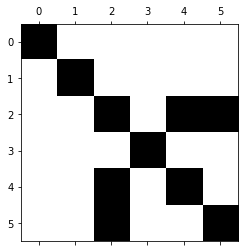

In [19]:
plt.spy(K)

In [20]:
print(K)

[[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+07  0.000e+00 -8.000e+05  1.600e+06]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -8.000e+05  0.000e+00  1.600e+06  0.000e+00]
 [ 0.000e+00  0.000e+00  1.600e+06  0.000e+00  0.000e+00  4.267e+06]]


In [21]:
print(F)

[[   0.]
 [   0.]
 [2580.]
 [   0.]
 [  60.]
 [1700.]]


In [22]:
U = np.linalg.solve(K, F)
U*1000

array([[ 0.   ],
       [ 0.   ],
       [ 0.219],
       [-0.   ],
       [ 0.147],
       [ 0.316]])

In [23]:
U.reshape(-1,2)*1000

array([[ 0.   ,  0.   ],
       [ 0.219, -0.   ],
       [ 0.147,  0.316]])

In [24]:
# результирующее положение узлов с учетом масштабного коэффициента
resNodes = Nodes + 1000*U.reshape(-1,2)

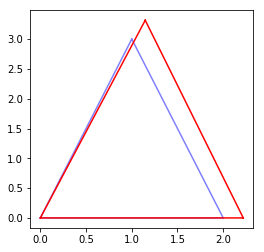

In [25]:
plt.figure(figsize=(4,4))
plt.triplot(Nodes[:,0], Nodes[:,1], [[0,1,2]], color='b', alpha=0.5)
plt.triplot(resNodes[:,0], resNodes[:,1], [[0,1,2]], color='r')

In [26]:
# Рассчитать тензор деформаций (зависит от перемещений узлов)
# Рассчитать тензор напряжений (зависит от деформаций)
# Вычислить главные напряжения

In [27]:
# [ Sx Txy 0]
# [Tyx  Sy 0]
# [  0  0  0]

In [28]:
eps = B.dot(U)
sig = D.dot(eps) - D.dot(eps0)
sig

array([[30.],
       [10.],
       [30.]])

In [29]:
s1 = 0.5*(sig[0] + sig[1]) + np.sqrt((0.5*(sig[0]-sig[1]))**2+sig[2]**2)
s2 = 0.5*(sig[0] + sig[1]) - np.sqrt((0.5*(sig[0]-sig[1]))**2+sig[2]**2)
s1[0], s2[0]

(51.62277660168378, -11.622776601683896)